In [83]:
print("hello")

hello


### We intend to build a recommendation system to increase the quality of products and ads that we show to customers , to do so we based our data on a dataset of the UK's retailers , we want to transform that data into a customer centric dataset to segmentate customers into different clusters 

In [84]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [85]:
# this is so we can use plotly localy in our notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [86]:
# Overwrite some style properties for Seaborn plots
sns.set_theme(rc={'axes.facecolor': '#7df9ff'}, style='darkgrid')

In [87]:
# Let's load the data
df = pd.read_csv("data.csv" , encoding="ISO-8859-1")
df_origin = df
# see what the data looks like 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [88]:
# see what the .csv file contains (columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### As we can see here there are 7 colums 
There is a total of 541909 entries and as you might have noticed , we have some missing data in some columns like CustomerID and Description 

In [89]:
# To further understand the data we will need to get more infor about it 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


#### As you can see we have a second problem : illogical values
- This can be observed by the fact the the min in both quatity and UnitPrice are negative  :'(
- This is the case of outliyers as shown by the 75% and 25% precentiles

In [90]:
# this includes the other feilds and the top most repeated words in each of them 
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


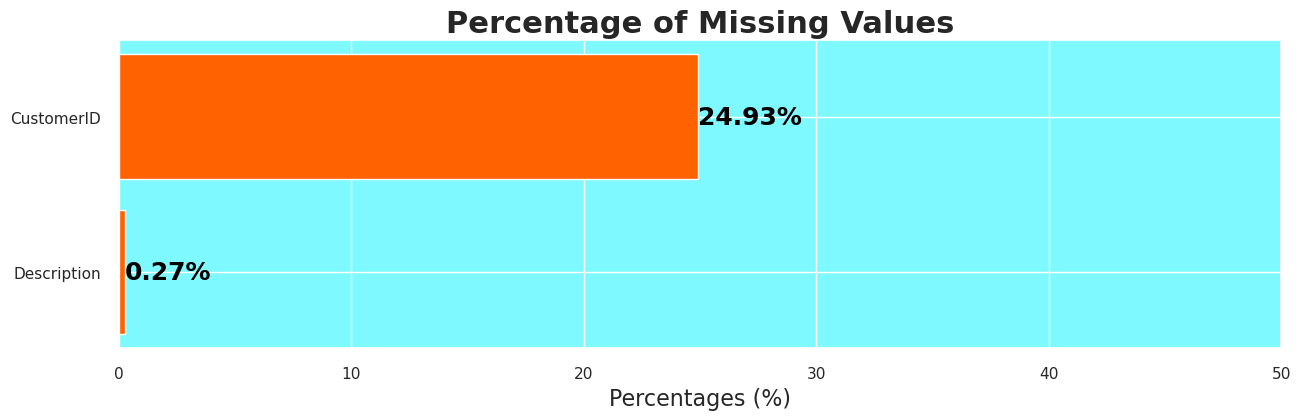

In [91]:
# calculating the mising data
missing_data = df.isnull().sum() # sums each colum seperatly
# give the percentage for each column
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100 # shapes the dataset to line-col (only lines in this case)
#                                                                      ^ forgot to multiply bruh

print(missing_data)
# Srting the vales so they are better presented 
missing_percentage.sort_values(ascending=True, inplace=True)

# Ploting 
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 50])

plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()





#### the imediate issue is that there is a quarter of customers data missing which is huuuge , and to avoid any bias here the most optimal solution is remove them and see how the data will behave 

#### while de Description data colums despite there being 1400~ values missing , it's nothing compared to the whole set as shown by the percentage

#### there are also inconsistencies we have to keep in mind as shown by the min and max values above 

- seeing the low precentage in the Description column it's better theoretically to remove these and potentially have a cleaner dataset

In [92]:
# let's remove the missing data from the dataset 
df = df.dropna(subset=['CustomerID', 'Description'])

In [93]:
print(df.isnull().sum())
# no missing data now 
# we can focus on inconsistencies and duplicates rn

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [94]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head(10)



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [95]:
print(f"number of duplacted values is : {df.duplicated().sum()}")

# removing the duplicates
df.drop_duplicates(inplace=True)


number of duplacted values is : 5225


/tmp/ipykernel_52370/3652470560.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
# (visualising the precentage of the data left after cleaning so far)
print(f"percentage of data left after cleaning is {(df.shape[0]/df_origin.shape[0])*100:.2f} %")

percentage of data left after cleaning is 74.11 %


In [97]:
# On thing that you might not have noticed is that Invoice despite it being (visually) a number it's not counted as one even after cleaning 
# which might indicate that there are string values somewhere m let's find out 

df.sort_values(['InvoiceNo'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541717,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [98]:
# as you can see here , there are values that start with C and negative Quatity which indicates that these are returned elements
# ofc we can't just leave it like like this 

# Filtering out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Let's take the cancelled returned elements/transactions 
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']

# we gonna peek at it now like a sussy little sh-
print(cancelled_transactions.describe().drop('CustomerID', axis=1))



           Quantity     UnitPrice
count   8872.000000   8872.000000
mean     -30.774910     18.899512
std     1172.249902    445.190864
min   -80995.000000      0.010000
25%       -6.000000      1.450000
50%       -2.000000      2.950000
75%       -1.000000      4.950000
max       -1.000000  38970.000000


/tmp/ipykernel_52370/868978554.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### As we can see the quatities are negative which does not indicate a problem in the data actually , but rather the returned elements and their quantities

### Looking at the Unit price we can see that the elements returned price values have a decent amount of variety 

### Important note : we do actually need to keep these data here since we want to know what products to recommend to customers and cancelled objects play an important role in that 

#### for one it enhances the clustering process by incorporating patterns and trends observed in cancellation data

#### secondly , it ,might prevent certain bad products from being recommended to to them being returned a lot of times

In [99]:
# to get an idea on what is the percentage of the returned item we do : 

print(f"Precentage of returned products : {(cancelled_transactions.shape[0] / df.shape[0]) * 100:.2f}%")

Precentage of returned products : 2.21%


In [100]:
# To get an idea of what are the top 10 products that sold where , we need first to get the unique codes for each product

unique_stock_codes = df['StockCode'].nunique()

print(f"The number of unique stock codes is: {unique_stock_codes} \n")

# to get the top 10 repeated one we use 
top_10_prods_code_num = df['StockCode'].value_counts().head(10) * 100 # kinda like a group by with addition to each iteration

top_10_prods_code_num

The number of unique stock codes is: 3684 



StockCode
85123A    206500
22423     189400
85099B    165900
47566     140900
84879     140500
20725     134600
22720     122400
POST      119600
22197     111000
23203     110800
Name: count, dtype: int64

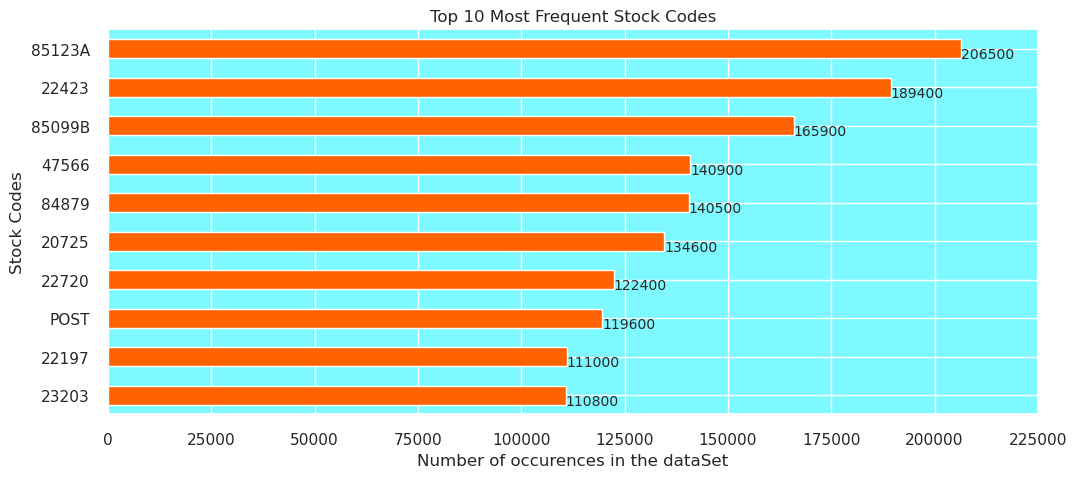

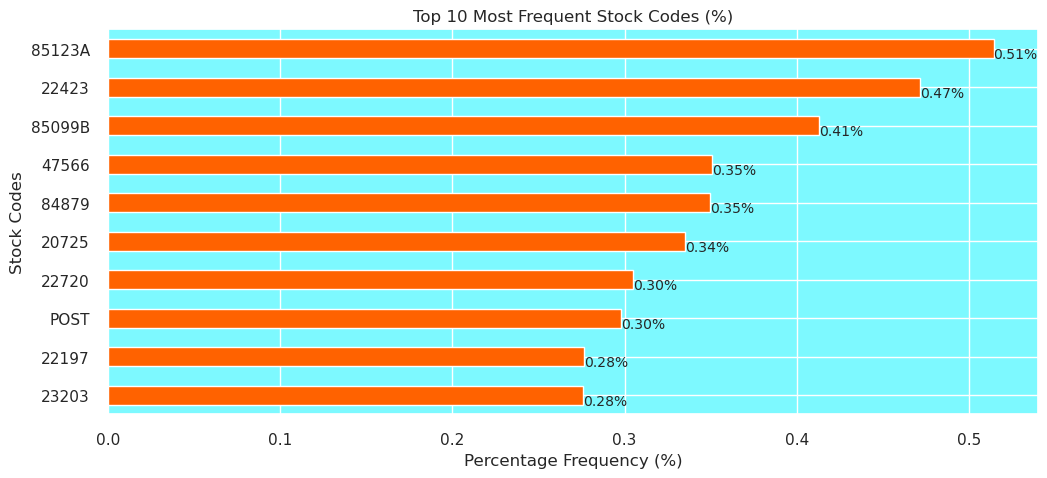

In [101]:

# same thing as above just wth percentages this time
top_10_prods_code_percentage = df['StockCode'].value_counts(normalize=True).head(10) * 100 

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_prods_code_num.plot(kind='barh', color='#ff6200')

# Loop on each barre to give it a description and a name (code name)
for index, value in enumerate(top_10_prods_code_num): # enumerate here is like taking the int value from the data given and looping around each one , 
    #at least from what i understood
    plt.text(value, index+0.25, value, fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Number of occurences in the dataSet')
plt.ylabel('Stock Codes')
plt.xlim([0,225000])
plt.gca().invert_yaxis()
plt.show()


# Plotting the top 10 most frequent stock codes in percentage
plt.figure(figsize=(12, 5))
top_10_prods_code_percentage.plot(kind='barh', color='#ff6200')

# Loop on each barre to give it a description and a name (code)
for index, value in enumerate(top_10_prods_code_percentage):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes (%)')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

### As we have seen above , there are 3684 unique stock codes in the dataset which implifies a large variety of products available for purchase

### This top 10 is gonna give an insight about the frequently ordered / popular products or categories

### Another thing you might have noticed and it's the code "POST" , this maybe related to postage fees perhaps or order deliveries ??

### we should further investigate theses "POST" code and see what they are later on 

In [102]:
# As you may have noticed most of the codes have 5 numerical values , except for "POST"
# to investigate we are gonna see the number of codes that have a 5 numerical values

unique_stock_codes = df['StockCode'].unique()
# this basically returns 2 values , one is the length of numerical vals (using lambda method and isdegit method)
# with valuecount , counting the number of occurences 
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Val | num of occurences for char len")
print("----------------------------------")
print(numeric_char_counts_in_unique_codes)


Val | num of occurences for char len
----------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


#### we can conclude that we have 7 codes that don't have any numerical characters in them (like POST above) and only one stock code with one numerical value

To investigate further we need to take a look at these special cases

In [103]:
# This will help us see what are the stock codes with 0 and 1 numeric characters
anomaly_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("----------------------")
for code in anomaly_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


#### Now supposedly we want to remove this data completely how much is its percentage compared to all the data 

In [104]:
anomaly_percentage = ((df['StockCode'].isin(anomaly_stock_codes).sum())/df.shape[0])*100

# the use of sum is quite smart here since the dataSet given here "df['StockCode'].isin(anomaly_stock_codes).sum()"
# Since we will just have True and false and since we are counting False as 0 , it basically only counts all the True rows 
print(f"percentage of anomaly records is : {anomaly_percentage:.2f}%")

percentage of anomaly records is : 0.48%


### Based on the percentage we can see that this represents a very small portion of our entire data so far these also have a high probability to not be products even as their name suggests "BANK CHARGES" and "POST"+ they represent 8 out of 3684 unique stock code 

### Thus for better accuracy for our prediction this anomalous stock codes data will be removed to focus more on actual products and proceed to the next step 

In [105]:
# Removing rows with anomalous stock codes from the dataset
# ? note: ~ helps flip the booleans in this case , to keep just the ones that are NOT in anomaly_stock_codes
df = df[~df['StockCode'].isin(anomaly_stock_codes)]

# check row count 
df.shape[0]

399689

### After cleaning the stock codes , it's time to check description to see if there is a similar behaviour as what we have seen above with stock codes 

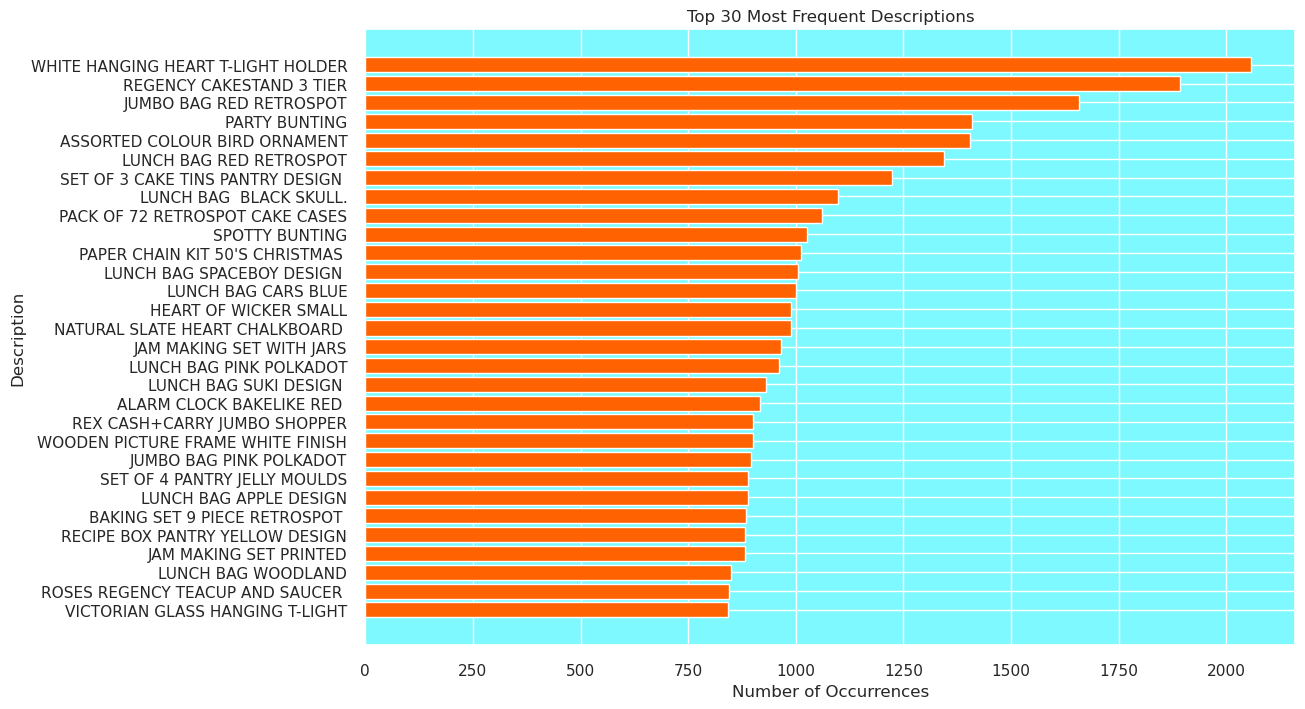

In [106]:
# Calculate the occurrence of each unique description and sort them
description_num = df['Description'].value_counts() # this is already sorted

# Get the top 30 descriptions
top_30_descriptions = description_num[:30]


# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

### We might have notices a pattern here 
- 1) Most of these items are household items associated with kitchenware, lunch bags, and decorative items
- 2) You may have noticed that all the names are in uppercase , which might indicate a tandardized format for entering product descriptions in the database , HOWEVER as we might have seen above there might be some inconsistencies , so we'll have to check for lowercase words as it is the most probable difference due to the uppercase behviour.

In [107]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("------------------------------------------------------------")
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


#### Looking at these they all seem normal except for thse 2 :
- Next Day Carriage
- High Resolution Image

In [108]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

matches1 = pd.Series(df['Description']).apply(lambda x: (str(x)==service_related_descriptions[0] or str(x)==service_related_descriptions[1])).value_counts(normalize=True)

print(f"The service related description represent {matches1.iloc[1]*100:.2f}% of the dataset")

The service related description represent 0.02% of the dataset


In [109]:
# since the percentage is so low and again for the sake of consistency it is safer to remove this data
df = df[~df['Description'].isin(service_related_descriptions)]

# again for consitency , we will uppercase all the Description feilds
df['Description'] = df['Description'].str.upper()


# Getting the number of rows left in the dataframe
df.shape[0]

399606

### After checking the description we will have to address the 0 values in the unite price field 

In [110]:
# checking the UnitePrice column again 
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

### The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error.

### either way we will have to check it out , to understand the nature and behaviour of this data

In [111]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


### Things noticed
- the number of these 0 transactions is fairly low at only 33 transactions
- the range is HUGE as indicated by the standard diviation , the min and the max , which might indicate potetial error data , and no one wants that.

### What to do
-> yoink it out of the dataset to avoid problems

In [112]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

### We will try using K-means algoritm later for clustering our data ,to do that we will have to address outliers as k-means is very sensitive to both the scale of data and the presence of outliers

### BUT! , at this stage, the data is transactional, and removing outliers might eliminate valuable information that could play a crucial role in segmenting customers later on. Therefore, we will postpone the outlier treatment and proceed to the next stage for now.

In [113]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

# how much of the data is left
df.shape[0]

399573

### In order to create a comprehensive customer-centric dataset for clustering and recommendation, the following features can be engineered from the available data:
i read about RFM [here](https://www.datacamp.com/tutorial/introduction-customer-segmentation-python)
- RFM is a method for analyzing customer value and segmenting the customer base , it has 3 main parts:
  - Recency (R): This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.
  - Frequency (F): This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.
  - Monetary (M): This metric represents the total amount of money a customer has spent over a certain period.the bigger the number the more the customer's contribution in the business.

### All these metrics will help use define the customers behaviour and but we will need to approach each one separatly

#### 1- Recency
- this can be achieved in thos dataset by looking at the invoiceDates , i.e how many days since the customer last purchased something 
- a lower value means he came just recently
- a higher value may mean that the customer is or may not be interseted by the products

#### With this businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.

In [114]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase datefor each customer (basically using max for each customer and then resetting the indexing)
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()
print(most_recent_date)

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
# This is compared to the most recent date as the data dates back to 2010-2012 so we can't subtract the current system time for the sake of consistency
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
# just for visualization here
customer_data.drop(columns=['InvoiceDay'], inplace=True)

2011-12-09


In [115]:
# see what it looks like
# sort by days since last purschase
customer_data.head(10).sort_values(by='Days_Since_Last_Purchase')

,CustomerID,Days_Since_Last_Purchase
1,12347.0,2
3,12349.0,18
9,12356.0,22
5,12352.0,36
2,12348.0,75
6,12353.0,204
8,12355.0,214
7,12354.0,232
4,12350.0,310
0,12346.0,325


### side note here:
- the customer_data dataFrame we built will contain all the RFM features, so we are going to build on it 

#### 2- Frequency

- we will base off of 2 things here :
  - Total transactions : simply how many times they bought something , this will help understand the customer's engagement
  - Total Products purchased : the first one will not fit well in context withou knowing the the number of products they purschased and vis-versa
  
These features will be crucial in segmenting customers based on their buying frequency, which will determine the customer segments and what to recommend for him

In [116]:
# Calculate the total number of transactions made by each customer
# kinda like a similar approache to what we did above
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index() # sum all transactions for each unique customer
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True) # simple column rename


# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index() # similar thing to what we did above
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merging the new features into the customer_data dataframe
# This was a method i have never used before so , it's good to know :D 
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID') # merge  the colums of Total_Transactions and bind each row to its corresponding CustomerID
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID') # same thing here but for total_products_purchased

# display the customer RFM so far 
customer_data.head(10)


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196
5,12352.0,36,8,463
6,12353.0,204,1,20
7,12354.0,232,1,530
8,12355.0,214,1,240
9,12356.0,22,3,1573


#### 3- Frequency

- we will base off of 2 things here :
  - Total spent : this is different than the total transactions since here we are calculating the total amout of money they spent (for each customer) , it's calculated by summing the product of Quantity and UnitPrice for each customer 
  - Average Transaction Value: This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. You might ask why ? , well this is simply to understand the sending behaviour of the customer if they for example only like to purchase small/cheap products this number is going to be low and ig you can see the pattern i am going for here
  
These features will be crucial in segmenting customers based on their buying frequency, which will determine the customer segments and what to recommend for him

In [117]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity'] # the product of UnitPrice and quantity
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index() # group by customerID and sum

# Calculate the average transaction value for each customer
# we already have the total transactions for each costumer from total_transactions , so we merge it like we did to previous dataframes
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
# perform the calculation for each row 
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000
